# GEODOS data processing

In [6]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
import matplotlib

%matplotlib inline

## Read Logfile

In [7]:
fto = '/storage/stations/Polednik/geodos/2024/09/vez/6.TXT' 
fto = '/storage/stations/Polednik/geodos/2024/09/vez/7.TXT' # dve bourky

l=[]
l.extend(range(0,1034))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)

sn = df.loc[df[0]=='$AIRDOS',3]
fw = df.loc[df[0]=='$AIRDOS',2]
last = df.loc[df[0]=='$AIRDOS'].index
print ('s.n.: ',sn[0])
print ('f.v.: ',fw[0])
print(df.loc[df[0]=='$AIRDOS',1])
print(len(df))
print(last[-1:][0])

# keep only last run
#df.drop(df.index[:last[-1:][0]], inplace=True) 

s.n.:  1290c00806a20090b413a000a0000070
f.v.:  NaI(Tl)-D18x30
0         GEO_1024_v3
109228    GEO_1024_v3
218435    GEO_1024_v3
Name: 1, dtype: object
325820
218435


## Fill position and time (Galileo)

In [8]:
# remove $GNRMC without fix
df.drop(df.loc[(df[0]=='$GNRMC') & (df[2]=='V')].index, inplace=True)

df.loc[(df[0]=='$GNRMC'),'flag']=True
df.loc[(df[0]=='$HIST'),'flag']=False
df.flag = df.flag.fillna(method='ffill')
df['latf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',3])
df['lonf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',5])
#df.loc[(df[0]=='$TIME') & (df['flag']),'on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
#df['on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
df['on_miliseconds'] = pd.to_numeric(df.loc[(df[0]=='$TIME') & (df['flag']),1]) * 1000
df['miliseconds'] = pd.to_numeric(df.loc[df[0]=='$HIST',2]) * 1000
df['gps_time'] = df.loc[df[0]=='$GNRMC',1]
df['gps_date'] = df.loc[df[0]=='$GNRMC',9]
df['alt'] = df.loc[df[0]=='$GNGGA',9]
df.loc[(df[0]=='$GNRMC') & (df[6]=='E'),'lon_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[6]=='W'),'lon_hem']=-1
df.loc[(df[0]=='$GNRMC') & (df[4]=='N'),'lat_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[4]=='S'),'lat_hem']=-1
df['lat'] = (np.trunc(df['latf']/100) + (((df['latf']/100) - np.trunc(df['latf']/100)) * 100) / 60.0) * df['lat_hem']
df['lon'] = (np.trunc(df['lonf']/100) + ((df['lonf']/100) - np.trunc(df['lonf']/100)) * 100 / 60.0) * df['lon_hem']  
#df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f')#,errors='coerce')
df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f',errors='coerce')
df.drop('lon_hem', axis=1, inplace=True)
df.drop('lat_hem', axis=1, inplace=True)
df.drop('latf', axis=1, inplace=True)
df.drop('lonf', axis=1, inplace=True)
df.drop('gps_time', axis=1, inplace=True)
df.drop('gps_date', axis=1, inplace=True)
df['meas'] = df.index
#df['meas'] = df.loc[df[0]=='$HIST',1]
df.loc[df[0]=='$HITS','meas'] = np.nan
df.iloc[:,1034:] = df.iloc[:,1034:].fillna(method='ffill')
df.meas = df.meas.astype(int)
df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
df.drop(df[df[0]=='$GNRMC'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df['UTC'] = df['date'] + pd.to_timedelta(df['miliseconds'], unit='ms') - pd.to_timedelta(df['on_miliseconds'], unit='ms')
#df.drop('date', axis=1, inplace=True)
#df.drop('miliseconds', axis=1, inplace=True)
#df.drop('on_miliseconds', axis=1, inplace=True)
df.iloc[-10:]

,0,1,2,3,4,5,6,7,8,9,...,1033,flag,on_miliseconds,miliseconds,alt,lat,lon,date,meas,UTC
327650,$HIST,52996,662366.35,85212.75,1.81,2.66,-26,1228,1,52644,...,NaN,False,661635610.0,662366350.0,1308.7,49.064138,13.395039,2023-04-12 18:33:12,327650,2023-04-12 18:45:22.740
327651,$HITS,10,12078,32,32710,36,32930,28,48890,43,...,NaN,False,661635610.0,662366350.0,1308.7,49.064138,13.395039,2023-04-12 18:33:12,327650,2023-04-12 18:45:22.740
327652,$HIST,52997,662378.93,85188.50,1.81,2.66,-26,1246,5,52683,...,NaN,False,661635610.0,662378930.0,1308.7,49.064138,13.395039,2023-04-12 18:33:12,327652,2023-04-12 18:45:35.320
327653,$HITS,8,35779,27,57259,38,59335,467,65537,57,...,NaN,False,661635610.0,662378930.0,1308.7,49.064138,13.395039,2023-04-12 18:33:12,327652,2023-04-12 18:45:35.320
327654,$HIST,52998,662391.51,85177.25,1.81,2.66,-26,1269,2,52221,...,NaN,False,661635610.0,662391510.0,1308.7,49.064138,13.395039,2023-04-12 18:33:12,327654,2023-04-12 18:45:47.900
327655,$HITS,12,3556,46,8216,31,9156,39,20632,99,...,NaN,False,661635610.0,662391510.0,1308.7,49.064138,13.395039,2023-04-12 18:33:12,327654,2023-04-12 18:45:47.900
327656,$HIST,52999,662403.82,85224.75,1.88,2.66,-26,1291,2,52694,...,NaN,False,661635610.0,662403820.0,1308.7,49.064138,13.395039,2023-04-12 18:33:12,327656,2023-04-12 18:46:00.210
327657,$HITS,9,3420,56,11493,907,13512,87,20383,61,...,NaN,False,661635610.0,662403820.0,1308.7,49.064138,13.395039,2023-04-12 18:33:12,327656,2023-04-12 18:46:00.210
327658,$HIST,53000,662416.40,85218.00,1.81,2.66,-26,1307,1,52319,...,NaN,False,661635610.0,662416400.0,1308.7,49.064138,13.395039,2023-04-12 18:33:12,327658,2023-04-12 18:46:12.790
327659,$HITS,10,3481,248,11441,40,11644,27,16715,38,...,NaN,False,661635610.0,662416400.0,1308.7,49.064138,13.395039,2023-04-12 18:33:12,327658,2023-04-12 18:46:12.790


## Add individual events to histogram

In [9]:
HISTHITS = 25 # in version 3, number of channels in $HIST
HISTOGRAM = 8 # the first channel of histogram
FIRSTCH = 4

df.dropna(subset=['UTC'], inplace=True)
hist = df.loc[df[0]=='$HIST'].iloc[:,:HISTOGRAM+HISTHITS].copy()
hist.iloc[:,1:] = hist.iloc[:,1:].apply(pd.to_numeric,errors='coerce')
#hist[0] = df[0]
hist['alt'] = df['alt'].apply(pd.to_numeric,errors='coerce')
hist['lat'] = df['lat'].apply(pd.to_numeric,errors='coerce')
hist['lon'] = df['lon'].apply(pd.to_numeric,errors='coerce')
hist['meas'] = df['meas'].apply(pd.to_numeric,errors='coerce')
hist['UTC'] = df['UTC']
#hist.iloc[:,18:269] = 0
hist.set_index('meas', inplace=True)

hits = df.loc[df[0]=='$HITS'].copy()
#hits['meas'] = hist.index
hits.iloc[:,1:] = hits.iloc[:,1:].apply(pd.to_numeric)
hits['UTC'] = df['UTC']
hits.set_index('meas', inplace=True)


In [10]:
hits.loc[hits[1]>500,1]=500
hits.loc[:,[*map('h{:04}'.format, range(1050))]] = 0
try:
    durdev = 0
    for i in range(len(hits)):
        for j in range(hits.iloc[i,1]):
            hits.iloc[i,int(1042+hits.iloc[i,j*2+3])] +=1
except:
    print(i,j)
    raise
            
histogram = pd.DataFrame()
histogram = hist.iloc[:,HISTOGRAM+FIRSTCH:HISTOGRAM+HISTHITS]
histogram = histogram.join(hits.iloc[:,1043+HISTHITS:])
histogram['temperature'] = hist[4]
histogram['pressure'] = hist[3]
histogram['voltage'] = hist[5]
histogram['current'] = hist[6]
histogram['UTC'] = hist['UTC']

histogram = histogram.rename(columns={x:y for x,y in zip(histogram.columns[:1024],range(0,1024))})
#histogram.to_csv(dto + '/histogram.csv')
histogram[:5]

/tmp/ipykernel_7136/1170904603.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  histogram['temperature'] = hist[4]
/tmp/ipykernel_7136/1170904603.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  histogram['pressure'] = hist[3]
/tmp/ipykernel_7136/1170904603.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

,0,1,2,3,4,5,6,7,8,9,...,h1045,h1046,h1047,h1048,h1049,temperature,pressure,voltage,current,UTC
meas,,,,,,,,,,,,,,,,,,,,,
22,30,4,3,1,1.0,1.0,1.0,0,1,2.0,...,0,0,0,0,0,1.19,86625.25,2.66,-79,2023-03-20 17:43:38.660
24,38,4,1,0,1.0,3.0,2.0,1,2,2.0,...,0,0,0,0,0,1.19,86620.50,2.66,-48,2023-03-20 17:43:51.300
26,41,1,2,2,1.0,3.0,0.0,0,0,0.0,...,0,0,0,0,0,1.19,86623.50,2.66,-36,2023-03-20 17:44:03.960
28,39,0,4,0,1.0,0.0,2.0,2,1,0.0,...,0,0,0,0,0,1.19,86616.75,2.66,-30,2023-03-20 17:44:16.610
30,45,6,0,0,0.0,0.0,3.0,1,0,0.0,...,0,0,0,0,0,1.19,86610.75,2.66,-28,2023-03-20 17:44:29.260


In [ ]:
# Clamp values in hits[1] to a maximum of 500
hits[1] = np.minimum(hits[1], 500)

# Set columns in hits to zero using vectorized assignment
hits.loc[:, [f"h{str(i).zfill(4)}" for i in range(1050)]] = 0

# Replace the nested loop with a vectorized approach
try:
    # Define column offset based on hits[1] and apply counting across rows
    col_indices = (1042 + hits.iloc[:, hits[1] * 2 + 3].values).astype(int)
    hit_counts = np.add.at(hits.values, (np.arange(len(hits)), col_indices), 1)
except Exception as e:
    print("Error in vectorized operations:", e)
    raise

# Construct the histogram DataFrame as per original code
histogram = hist.iloc[:, HISTOGRAM + FIRSTCH:HISTOGRAM + HISTHITS]
histogram = histogram.join(hits.iloc[:, 1043 + HISTHITS:])
histogram['temperature'] = hist[4]
histogram['pressure'] = hist[3]
histogram['voltage'] = hist[5]
histogram['current'] = hist[6]
histogram['UTC'] = hist['UTC']

# Rename columns
histogram = histogram.rename(columns={x: y for x, y in zip(histogram.columns[:1024], range(0, 1024))})

# View the first few rows
histogram[:5]


## Plot Flux

/tmp/ipykernel_7136/1919753843.py:37: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_7136/1919753843.py:38: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='-')


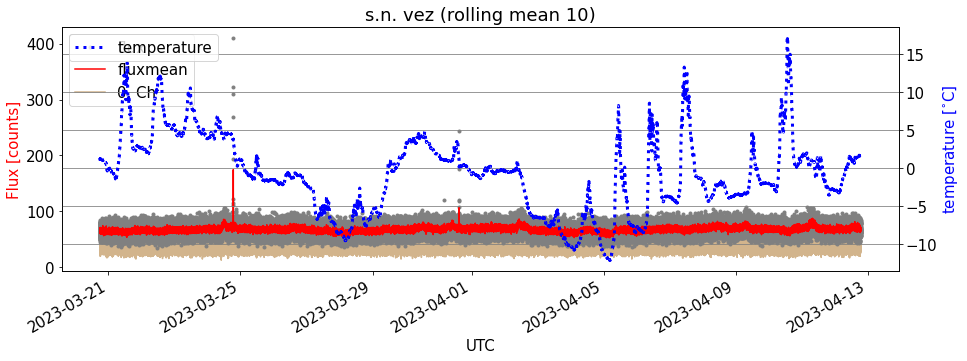

In [11]:
NOISE_LEVEL = 0
LAST_CHANNEL = 1023
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

#histogram.read_csv(dto + '/histogram.csv')
xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2023-03-24 07:00':'2023-03-25 00:00'] # 1. Vanice v Ceskem lese
#xx = xx.loc['2023-03-31 00:00':'2023-04-01 00:00'] # 2. Vanice v Ceskem lese

#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title("s.n. " + s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,350])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='blue', label='temperature', linewidth='3', linestyle=':', drawstyle='steps-post')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



/tmp/ipykernel_7136/1770162785.py:37: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_7136/1770162785.py:38: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='-')


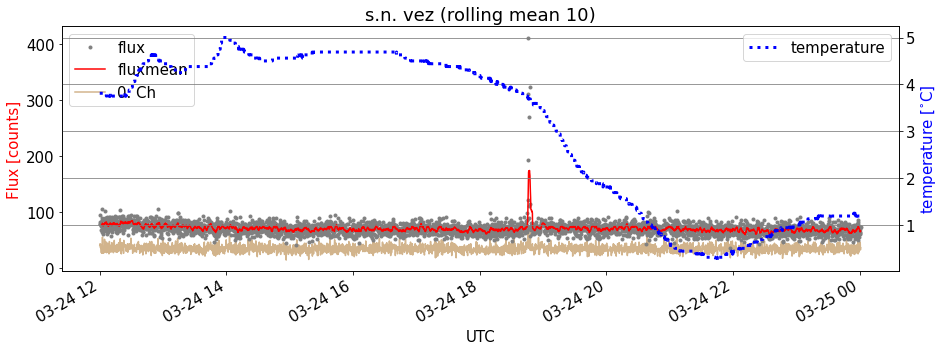

In [13]:
NOISE_LEVEL = 0
LAST_CHANNEL = 1023
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

#histogram.read_csv(dto + '/histogram.csv')
xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
xx = xx.loc['2023-03-24 12:00':'2023-03-25 00:00'] # 1. Vanice v Ceskem lese
#xx = xx.loc['2023-03-31 00:00':'2023-04-01 00:00'] # 2. Vanice v Ceskem lese

#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title("s.n. " + s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,350])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='blue', label='temperature', linewidth='3', linestyle=':', drawstyle='steps-post')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



/tmp/ipykernel_7136/295893437.py:28: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_7136/295893437.py:29: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='-')


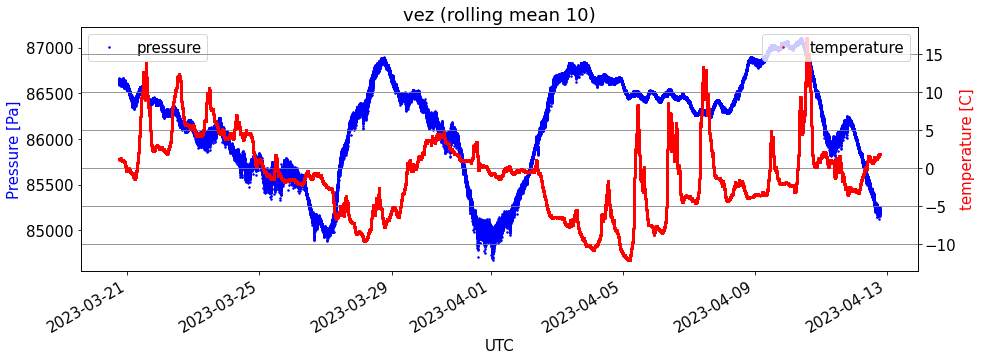

In [19]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']



xx['pressure'].plot(c='blue', linestyle='', marker='.', ms=3, label = 'pressure')

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Pressure [Pa]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('temperature [C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend(loc=1)



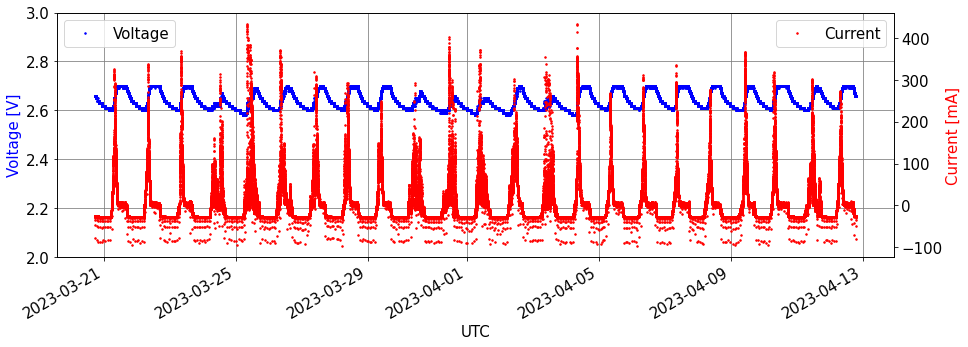

In [15]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']



xx['voltage'].plot(c='blue', linestyle='', marker='.', ms=3, label = 'Voltage')

s = fto.split('/')
#plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
plt.ylim([2,3])
plt.xlabel('UTC')
plt.ylabel(r'Voltage [V]', color='blue')
plt.legend(loc=2)
plt.grid(visible=True, which='major', color='grey', linestyle='-')
plt.grid(visible=True, which='minor', color='grey', linestyle='-')

ax = plt.twinx()

#plt.ylim([0,14000])
xx['current'].plot(c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('Current [mA]', color='red')

plt.legend()



/tmp/ipykernel_7136/2764776834.py:38: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_7136/2764776834.py:39: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='-')


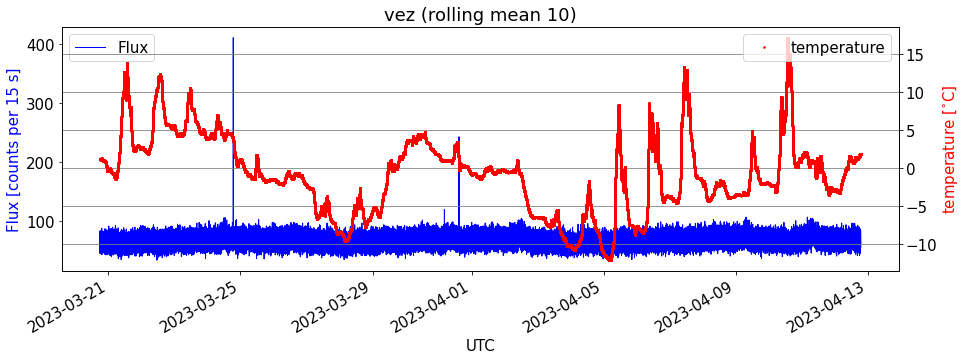

In [18]:
NOISE_LEVEL = 0
LAST_CHANNEL = 1023
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

#xx['flux'].plot(c='gray', marker='.', linewidth=1)
xx['flux'].plot(c='blue', linewidth=1, label='Flux')
#xx['fluxmean'].plot(c='red')
#(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts per 15 s]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend(loc=1)



# Blitzortung

In [80]:
# Load of lightning data
filename = '/storage/blitzortung/2021-2023/region-1/2023-03-24.log'

blitz = pd.read_csv(filename, sep=',', low_memory=False, on_bad_lines='skip')


In [81]:
sitename = 'Polednik'
lat = 49.063936
lon = 13.395348

FROM = '2023-03-24 00:00'
TO = '2023-03-25 00:00'

start=pd.Timestamp(FROM)
end=pd.Timestamp(TO)


In [82]:
# Reduction of distant lightnings

BLITZ_DIST = 100

blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz = blitz.loc[blitz['km'] <= BLITZ_DIST]
blitz.reset_index(inplace=True)

blitz['date'] = pd.to_datetime(blitz['time'])
blitz.set_index('date', inplace=True)


/tmp/ipykernel_7136/1608578412.py:10: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  blitzblitz = blitz.loc[FROM:TO]
/tmp/ipykernel_7136/1608578412.py:17: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax3.grid(b=True, which='major', color='lightgrey', linestyle='-')
/tmp/ipykernel_7136/1608578412.py:26: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax4.grid(b=True, which='major', color='lightgrey', linestyle='-')
/tmp/ipykernel_7136/1608578412.py:32: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases lat

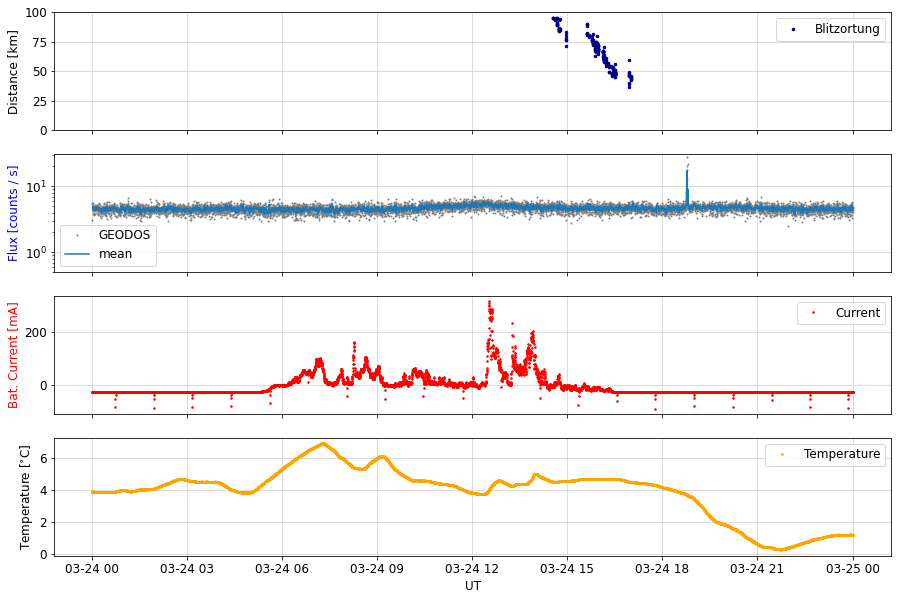

In [83]:
WINDOW = 5

fig, (ax6, ax3, ax5, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(15,10))
matplotlib.rcParams.update({'font.size': 12})

xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
xx = xx.loc[FROM:TO]

blitzblitz = blitz.loc[FROM:TO]

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))
xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

ax3.plot(xx['flux']/15, marker='.', color='gray', label='GEODOS', ms=2, linestyle='none')
ax3.plot(xx['fluxmean']/15, label='mean')
ax3.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax3.set_ylabel(r'Flux [counts / s]', color='blue')
ax3.set_yscale('log')
ax3.set_ylim(0.5,)
ax3.legend()

ax4.plot(xx['temperature'], c='orange', label='Temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax4.set_xlabel('UT')
ax4.set_ylabel(r'Temperature [$^{\circ}$C]')
ax4.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax4.legend()

ax6.plot(blitzblitz.index, blitzblitz.km, ls='', marker='.', ms=5, label='Blitzortung', c='darkblue')
ax6.set_ylabel('Distance [km]')
ax6.legend()
ax6.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax6.set_ylim(0,100)

ax5.plot(xx['current'], c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax5.set_ylabel('Bat. Current [mA]', color='red')
ax5.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax5.legend()


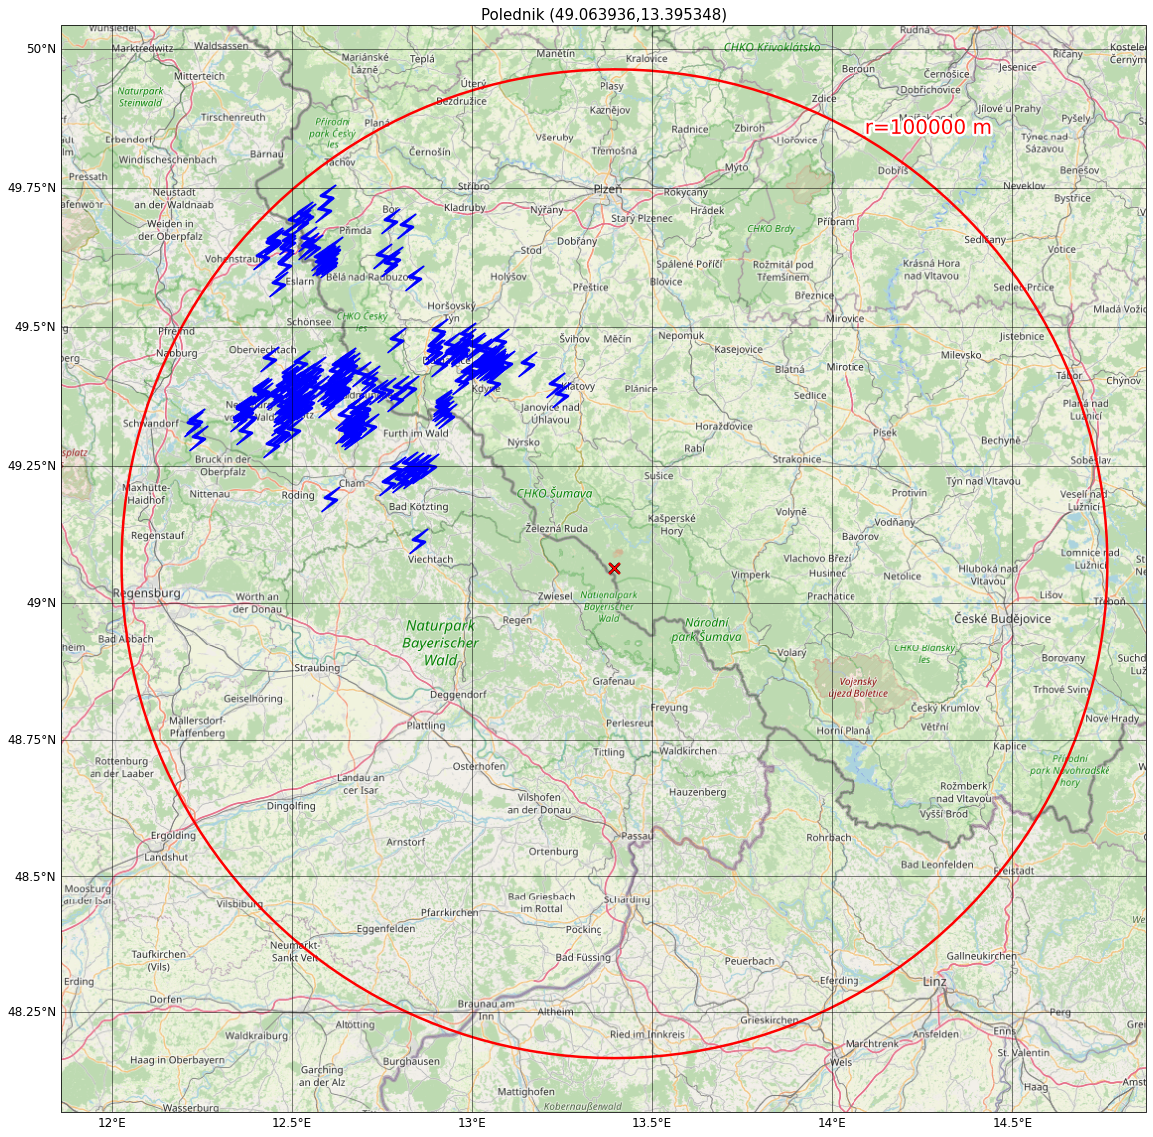

In [84]:
__title__   = 'Plot OpenStreetMap site map'
__version__ = 'v1.0 (2021-03-02)'
__author__  = 'Mathew Lipson'
__email__   = 'm.lipson@unsw.edu.au'

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import cartopy
import cartopy.geodesic as cgeo
import cartopy.crs as ccrs

import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
import shapely

projpath = '.'

##########################################################################

def main():

        
    RADIUS = 100000
    
    # style can be 'map' or 'satellite'

    #for style in ['map','satellite']:

    osm_image(lon, lat, sitename=sitename, style='map', radius=RADIUS)

    return

##########################################################################

def osm_image(lon,lat,sitename='Columbo',style='satellite',radius=500):
    '''This function makes OpenStreetMap satellite or map image with circle and random points.
    Change np.random.seed() number to produce different (reproducable) random patterns of points.
    Also review 'scale' variable'''

    if style=='map':
        ## MAP STYLE
        cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.OSM() # spoofed, downloaded street map
    elif style =='satellite':
        # SATELLITE STYLE
        cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.QuadtreeTiles() # spoofed, downloaded street map
    else:
        print('no valid style')

    stroke = [pe.Stroke(linewidth=1, foreground='w'), pe.Normal()]

    ############################################################################

    plt.close('all')
    fig = plt.figure(figsize=(20,20)) # open matplotlib figure
    ax = plt.axes(projection=img.crs) # project using coordinate reference system (CRS) of street map
    data_crs = ccrs.PlateCarree()

    ax.set_title(f'{sitename} ({lat},{lon})',fontsize=15)

    # auto-calculate scale
    #scale = int(120/np.log(radius))
    scale = int(115/np.log(radius))
    scale = (scale<20) and scale or 19

    # or change scale manually
    # NOTE: scale specifications should be selected based on radius
    # but be careful not have both large scale (>16) and large radius (>1000), 
    #  it is forbidden under [OSM policies](https://operations.osmfoundation.org/policies/tiles/)
    # -- 2     = coarse image, select for worldwide or continental scales
    # -- 4-6   = medium coarseness, select for countries and larger states
    # -- 6-10  = medium fineness, select for smaller states, regions, and cities
    # -- 10-12 = fine image, select for city boundaries and zip codes
    # -- 14+   = extremely fine image, select for roads, blocks, buildings

    extent = calc_extent(lon,lat,radius*1.1)
    ax.set_extent(extent) # set extents
    ax.add_image(img, int(scale)) # add OSM with zoom specification

    # add site
    ax.plot(lon,lat, color='black', marker='x', ms=10, mew=3, transform=data_crs)
    ax.plot(lon,lat, color='red', marker='x', ms=11, mew=2, transform=data_crs)

    #lightning = blitz.loc['2021-08-15 16:00:00':'2021-08-15 20:00:00']
    lightning = blitz
    #lightning = blitz.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']
    #ax.plot(lightning.lon,lightning.lat,color='blue',lw=0,marker='$\u21AF$',ms=25,mew=1.0,transform=data_crs)
    #ax.plot(lightning.lon,lightning.lat,color='black',lw=0,marker='$\u26A1$',ms=35,mew=1.0,transform=data_crs)
    ax.plot(lightning.lon,lightning.lat,color='blue',lw=0,marker='$\u26A1$',ms=25,mew=1.0,transform=data_crs)

    # Cas jednotlivych bodu
    #for index, row in lightning.iterrows():
    #    ax.text(row.lon, row.lat, row.UTC, color='red', fontsize=10, ha='left',va='bottom', transform=data_crs)


    # add cartopy geodesic circle
    circle_points = cgeo.Geodesic().circle(lon=lon, lat=lat, radius=radius)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), edgecolor='red', facecolor='none', linewidth=2.5)

    radius_text = cgeo.Geodesic().direct(points=(lon,lat),azimuths=30,distances=radius)[:,0:2][0]
    stroke = [pe.Stroke(linewidth=5, foreground='w'), pe.Normal()]
    ax.text(radius_text[0],radius_text[1],f'r={radius} m', color='red', 
        fontsize=20, ha='left',va='bottom', path_effects=stroke, transform=data_crs)

    gl = ax.gridlines(draw_labels=True, crs=data_crs,
                        color='k',lw=0.5)

    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER

    plt.show()

    #fig.savefig(f'{projpath}/{sitename}_{style}_r{radius}_pts{npoints}_scale{scale}.jpg', dpi=150, bbox_inches='tight')

    return

def calc_extent(lon,lat,dist):
    '''This function calculates extent of map
    Inputs:
        lat,lon: location in degrees
        dist: dist to edge from centre
    '''

    dist_cnr = np.sqrt(2*dist**2)
    top_left = cgeo.Geodesic().direct(points=(lon,lat),azimuths=-45,distances=dist_cnr)[:,0:2][0]
    bot_right = cgeo.Geodesic().direct(points=(lon,lat),azimuths=135,distances=dist_cnr)[:,0:2][0]

    extent = [top_left[0], bot_right[0], bot_right[1], top_left[1]]

    return extent

def image_spoof(self, tile):
    '''this function reformats web requests from OSM for cartopy
    Heavily based on code by Joshua Hrisko at:
        https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy'''

    url = self._image_url(tile)                # get the url of the street map API
    req = Request(url)                         # start request
    req.add_header('User-agent','Anaconda 3')  # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read())            # get image
    fh.close()                                 # close url
    img = Image.open(im_data)                  # open image with PIL
    img = img.convert(self.desired_tile_form)  # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

if __name__ == "__main__":

   main()

# Energy Spectrum

(0.0, 20.0)

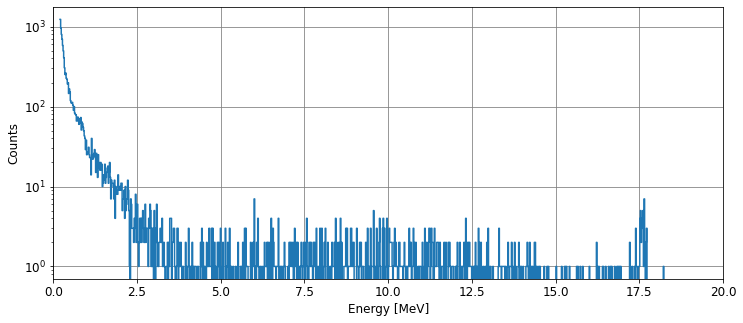

In [86]:
yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)

yy = yy.loc['2023-03-24 18:00':'2023-03-24 19:00'] # 1. Vanice v Ceskem lese

#yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:1024],range(0,1024))})
ener = yy.iloc[:,1:1024].sum()
ener = ener.reset_index()
ener['ener'] = 0.018 * ener.index + 0.2

plt.figure(figsize=(12,5))
plt.plot(ener['ener'], ener[0], drawstyle='steps-post')
plt.yscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
plt.xlim([0,20])
#plt.ylim([0,250])

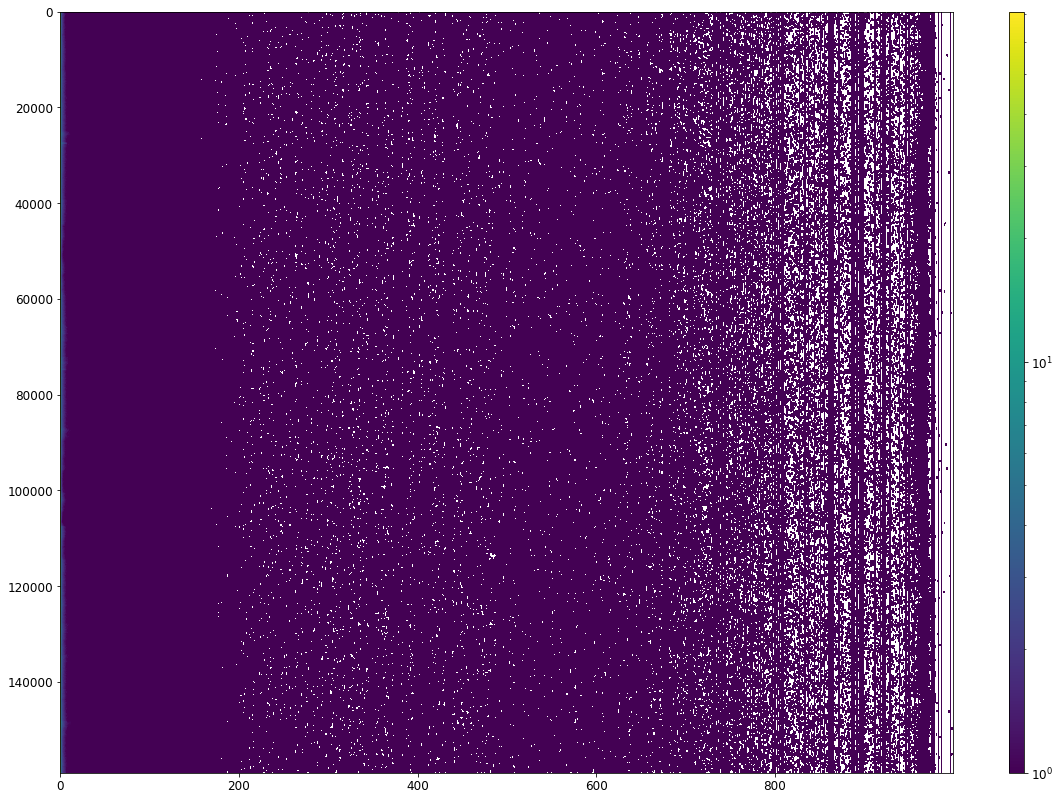

In [88]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(20, 14))
plt.imshow((histogram.iloc[:,0:1000]), aspect='auto', norm=LogNorm())
plt.colorbar(aspect=50)
None